# Investigate alleles that increased abundance

Almost all variants with abundance changes that surpass assay variability are decreases in abundance. For the very few cases that increased abundance, we want to see if there is anything biologically interesting going on here.

In [39]:
import polars as pl
import sys
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
sys.path.append("../..")
from utils import *

In [40]:
outputs_dir = "../3_outputs"

## 1. Variants with increased abundance

In [41]:
scores = pl.read_csv(f"{outputs_dir}/annotated_perturbation_scores.csv", infer_schema_length=1000000)
incr_abun = scores.filter(pl.col("zscore_log2") > 1.96)
print(incr_abun.select(['symbol', 'aa_change', 'zscore_log2', 'clinvar_clnsig_clean', 'StarStatus']))

shape: (15, 5)
┌────────┬───────────┬─────────────┬──────────────────────┬────────────┐
│ symbol ┆ aa_change ┆ zscore_log2 ┆ clinvar_clnsig_clean ┆ StarStatus │
│ ---    ┆ ---       ┆ ---         ┆ ---                  ┆ ---        │
│ str    ┆ str       ┆ f64         ┆ str                  ┆ i64        │
╞════════╪═══════════╪═════════════╪══════════════════════╪════════════╡
│ SH3BP2 ┆ Gly420Arg ┆ 2.593702    ┆ 1_Pathogenic         ┆ null       │
│ MID1   ┆ Pro151Leu ┆ 3.206029    ┆ 4_VUS                ┆ 1          │
│ KLHL3  ┆ Glu85Ala  ┆ 3.818985    ┆ 1_Pathogenic         ┆ null       │
│ KLHL3  ┆ Ala77Glu  ┆ 3.717149    ┆ 1_Pathogenic         ┆ null       │
│ ALAS2  ┆ Ile439Asn ┆ 2.010533    ┆ 1_Pathogenic         ┆ null       │
│ MID1   ┆ Lys370Glu ┆ 2.16138     ┆ null                 ┆ null       │
│ TPM1   ┆ Lys15Asn  ┆ 4.117871    ┆ 3_Conflicting        ┆ 1          │
│ BAG3   ┆ Leu462Pro ┆ 4.159525    ┆ 1_Pathogenic         ┆ 1          │
│ TPM1   ┆ Ala22Thr  ┆ 3.297966    ┆

## 2. Group the variants by gene

In [42]:
symbol_medians = scores.filter(~pl.col("zscore_log2").is_null()).group_by("symbol").agg(
    pl.col("zscore_log2").median().alias("median_log2")
).sort("median_log2")

symbol_order = symbol_medians.select('symbol').to_series().to_list()

scores_plot = scores.join(symbol_medians, on="symbol").to_pandas()
scores_plot['symbol'] = pd.Categorical(scores_plot['symbol'], categories=symbol_order, ordered=True)
scores_plot

,symbol,nt_change,aa_change,gene_variant,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,...,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,dualipa_abund_change,dualipa_assayed,dualipa_threshold,median_log2
0,KCNJ2,899G>A,Gly300Asp,KCNJ2_Gly300Asp,693.679993,5069.049805,0.133067,0.841771,0.158080,-1.835174,...,None,None,None,None,None,None,True,True,-2.477405,-5.859161
1,HBD,174C>A,Asn58Lys,HBD_Asn58Lys,33.840000,2474.280029,0.012192,0.077713,0.156882,-1.837623,...,None,None,None,None,None,None,True,True,-2.477405,-5.834380
2,SMAD3,376C>T,His126Tyr,SMAD3_His126Tyr,993.600037,3757.339966,0.267095,1.033889,0.258340,-1.630252,...,None,None,None,None,None,None,True,True,-2.477405,-0.819028
3,HBD,110C>A,Pro37His,HBD_Pro37His,31.959999,3535.250000,0.008351,0.077713,0.107457,-1.938643,...,None,None,None,None,None,None,True,True,-2.477405,-5.834380
4,KRT2,558C>A,Asn186Lys,KRT2_Asn186Lys,214.760010,2279.899902,0.095686,0.304336,0.314409,-1.515652,...,None,None,None,None,None,None,True,True,-2.477405,-3.230985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,SMAD3,335C>T,Ala112Val,SMAD3_Ala112Val,963.700012,2708.780029,0.357096,1.033889,0.345391,-1.452326,...,None,None,None,None,None,None,True,True,-2.477405,-0.819028
737,GCK,131G>A,Gly44Asp,GCK_Gly44Asp,2746.079956,2448.382416,1.085445,1.730655,0.660002,-0.809289,...,None,None,None,None,None,None,False,True,-2.477405,-1.953208
738,PKP2,1114G>C,Ala372Pro,PKP2_Ala372Pro,1100.090027,1425.280029,0.698059,0.629182,1.109471,0.109389,...,None,None,None,None,None,None,False,True,-2.477405,-0.061359
739,STXBP1,539G>A,Cys180Tyr,STXBP1_Cys180Tyr,612.869995,2037.875000,0.289300,1.265654,0.228578,-1.691083,...,None,None,None,None,None,None,True,True,-2.477405,-4.714443


<Figure size 640x480 with 0 Axes>

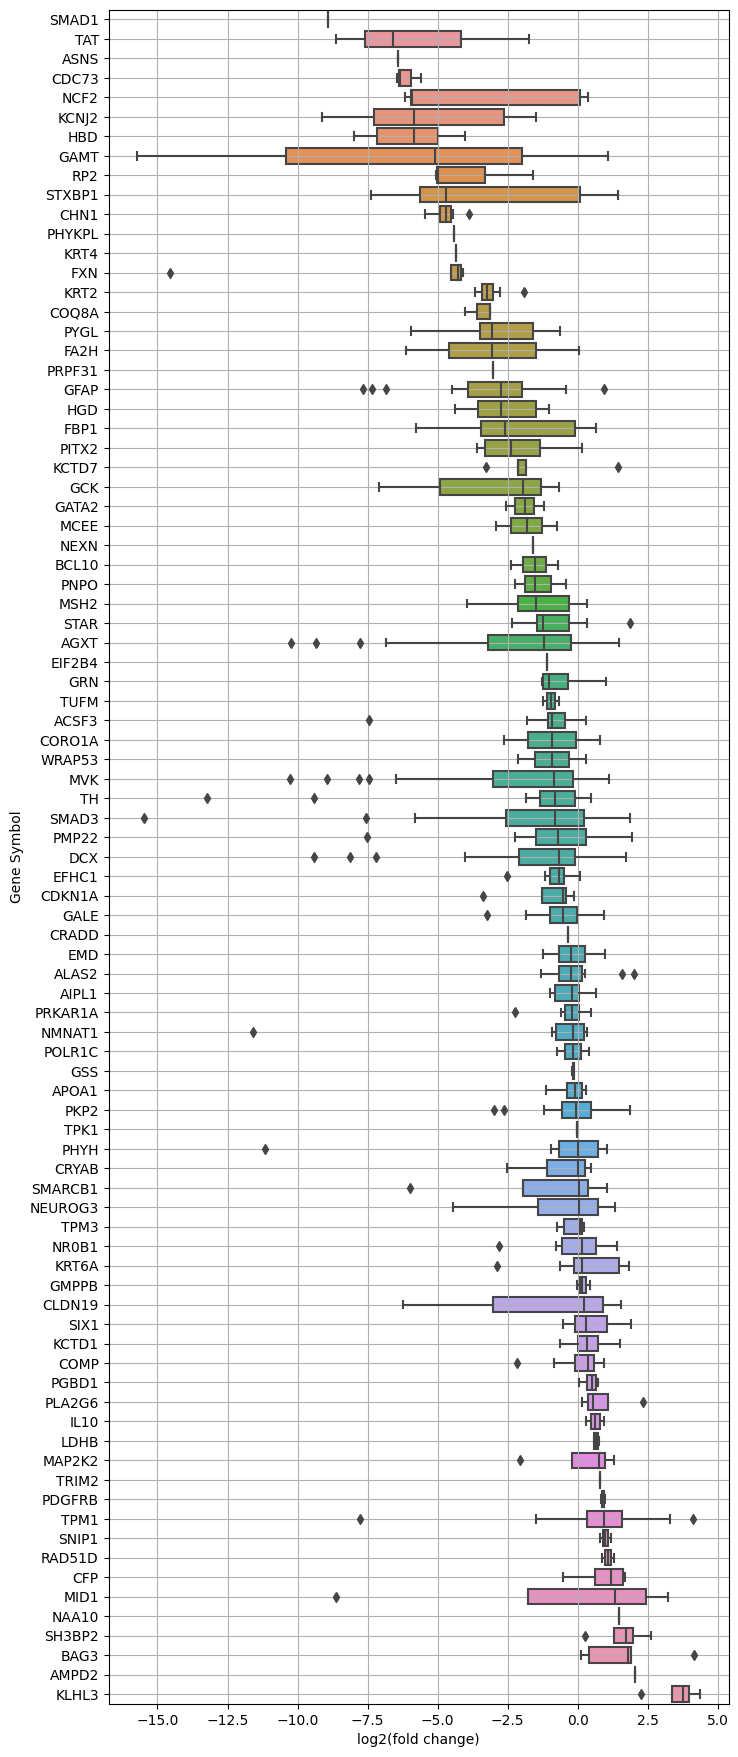

In [43]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(8, 22))
sns.boxplot(data=scores_plot, x="zscore_log2", y="symbol", ax=ax)
ax.set_xlabel("log2(fold change)")
ax.set_ylabel("Gene Symbol")
ax.grid()
plt.show()

<Figure size 640x480 with 0 Axes>

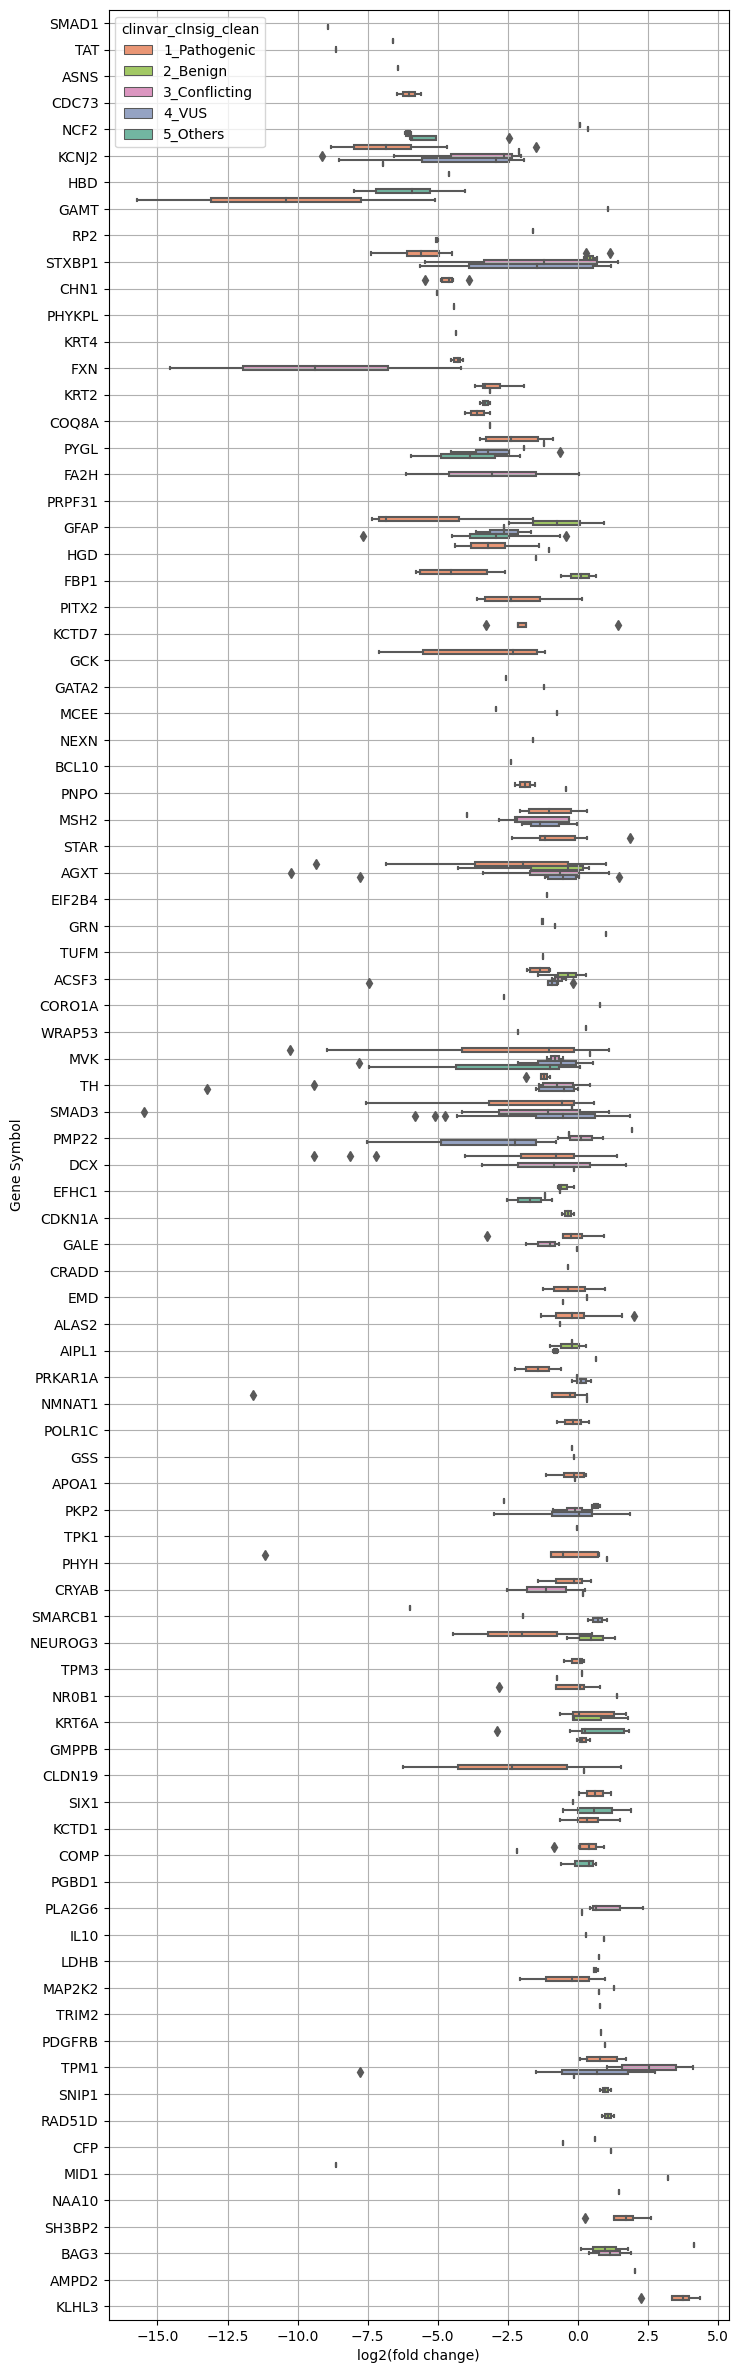

In [44]:
plt.clf()
fig, ax = plt.subplots(1,1,figsize=(8, 30))
sns.boxplot(data=scores_plot, x="zscore_log2", y="symbol", 
            palette=palette_dict["clinvar_clnsig_clean"], ax=ax, 
            hue="clinvar_clnsig_clean", 
            hue_order=sorted(scores_plot.dropna(subset="clinvar_clnsig_clean")["clinvar_clnsig_clean"].unique())
           )
ax.set_xlabel("log2(fold change)")
ax.set_ylabel("Gene Symbol")
ax.grid()
plt.show()

## 3. Map with Pillar Project

gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 1 name,Interval 1 MaveDB class,zscore_log2
str,str,str,str,str,f64
"""GCK_Met381Arg""","""GCK_Met381Arg""","""1_Pathogenic""","""Low abundance ""","""Abnormal""",-2.326245
"""MSH2_Arg96His""","""MSH2_Arg96His""","""2_Benign""","""Loss of function""","""Abnormal""",-3.96477
"""GCK_Gly178Arg""","""GCK_Gly178""",null,"""Decreased activity""","""Abnormal""",-0.686217
"""MSH2_Gly40Ser""","""MSH2_Gly40Ser""","""3_Conflicting""","""Loss of function""","""Abnormal""",-0.312483
"""MSH2_Ala714Val""","""MSH2_Ala714Val""","""3_Conflicting""","""Loss of function""","""Abnormal""",-2.156276
"""MSH2_Leu687Pro""","""MSH2_Leu687Pro""","""1_Pathogenic""","""Loss of function""","""Abnormal""",-1.62861
"""MSH2_Leu92Val""","""MSH2_Leu92Val""","""3_Conflicting""","""Loss of function""","""Abnormal""",-0.310709
"""MSH2_Gln409Lys""","""MSH2_Gln409Lys""","""4_VUS""","""Loss of function""","""Abnormal""",-1.998023
"""MSH2_Leu440Pro""","""MSH2_Leu440Pro""","""1_Pathogenic""","""Loss of function""","""Abnormal""",0.326193


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 2 name,Interval 2 MaveDB class,zscore_log2
str,str,str,str,str,f64
"""MSH2_Gly40Ser""","""MSH2_Gly40Ser""","""3_Conflicting""","""WT-like""","""Normal""",-0.312483
"""MSH2_Leu92Val""","""MSH2_Leu92Val""","""3_Conflicting""","""WT-like""","""Normal""",-0.310709
"""MSH2_Ala714Val""","""MSH2_Ala714Val""","""3_Conflicting""","""WT-like""","""Normal""",-2.156276
"""GCK_Arg377His""","""GCK_Arg377His""","""1_Pathogenic""","""Hyperactive""","""Not specified""",-4.287583
"""MSH2_Leu687Pro""","""MSH2_Leu687Pro""","""1_Pathogenic""","""WT-like""","""Normal""",-1.62861
"""MSH2_Ala305Thr""","""MSH2_Ala305Thr""","""3_Conflicting""","""WT-like""","""Normal""",-2.803915
"""MSH2_Thr335Ile""","""MSH2_Thr335Ile""","""4_VUS""","""WT-like""","""Normal""",-1.342705
"""MSH2_Lys627Asn""","""MSH2_Lys627Asn""",null,"""WT-like""","""Normal""",-0.262096
"""MSH2_Glu562Val""","""MSH2_Glu562Val""","""3_Conflicting""","""WT-like""","""Normal""",-2.224665


gene_variant,gene_variant_pp,clinvar_clnsig_clean,Interval 3 name,Interval 3 MaveDB class,zscore_log2
str,str,str,str,str,f64
"""GCK_Arg377His""","""GCK_Arg377His""","""1_Pathogenic""","""Synonymous""","""Abnormal""",-4.287583
"""GCK_Gly178Arg""","""GCK_Gly178""",null,"""Synonymous""","""Abnormal""",-0.686217


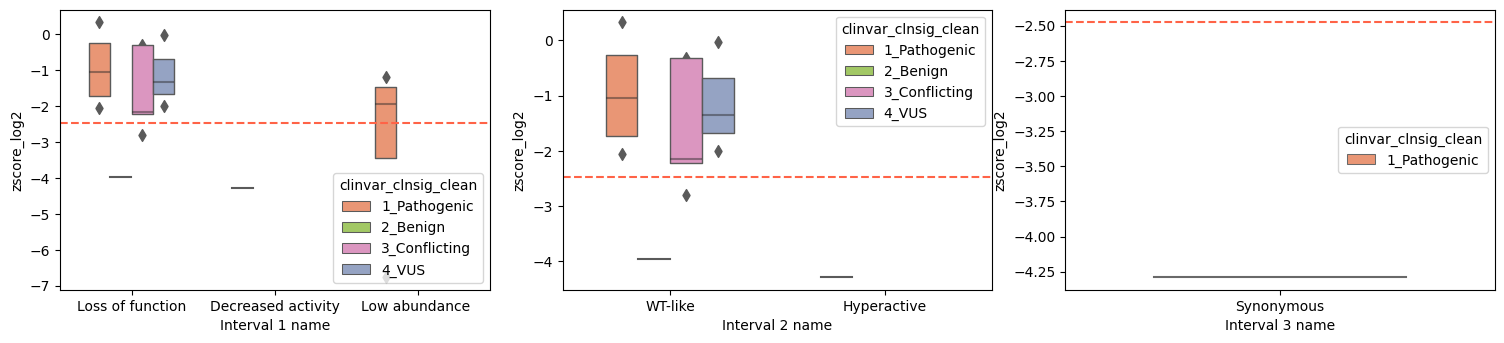

In [54]:
func_scores = scores.filter(pl.col("pillar_tested"))
pl.Config.set_tbl_rows(25)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

fig, axes = plt.subplots(2, 4, figsize=(25,8))
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_mave = func_scores.drop_nulls(pl.col(mavedb_name))
    if func_mave.shape[0] > 0:
        # display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name, "zscore_log2"])
        # fig, ax = plt.subplots(1,2,figsize=(15,6))
        hue_order = sorted(func_mave.drop_nulls("clinvar_clnsig_clean").unique("clinvar_clnsig_clean")["clinvar_clnsig_clean"])
        sns.boxenplot(
            data=func_mave.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y="zscore_log2",
            ax=axes.flatten()[i-1],
            palette=palette_dict["clinvar_clnsig_clean"], 
            hue="clinvar_clnsig_clean", 
            hue_order=hue_order,
            dodge="auto",
            width=.6,
        )
        display(func_mave.unique(subset="gene_variant").select(
            ["gene_variant", "gene_variant_pp","clinvar_clnsig_clean", int_name, mavedb_name, "zscore_log2"]
        ))
        axes.flatten()[i-1].axhline(func_mave["dualipa_threshold"].to_numpy()[0], color="tomato", linestyle="--")
        # sns.boxenplot(
        #     data=func_mave.unique(subset="gene_variant").to_pandas(),
        #     x=mavedb_name,
        #     y="zscore_log2",
        #     ax=ax[1],
        #     palette=palette_dict["clinvar_clnsig_clean"],
        #     hue="clinvar_clnsig_clean", 
        #     hue_order=hue_order,
        #     dodge=True
        # )
    else:
        fig.delaxes(axes.flatten()[i-1])

fig.delaxes(axes.flatten()[6])
fig.delaxes(axes.flatten()[7])
plt.subplots_adjust(wspace=0.17)
plt.show()